# Modelo de cruce de calles

This notebook presents a tutorial for beginners on how to create a simple agent-based model with the [agentpy](https://agentpy.readthedocs.io) package. 
It demonstrates how to create a basic model with a custom agent type, run a simulation, record data, and visualize results.

In [2]:
# Model design
import agentpy as ap
import numpy as np 
import random
# Visualization
import seaborn as sns
import pandas as pd

In [156]:
def abs(x):
    if x<0:
        x = x*-1
    return x
eSeed = 42

## Definicion del modelo

Se declara el agente carro

In [157]:
val = ["arriba","izquierda","abajo","derecha"]
arr = 0
izq = 0
aba = 0
der = 0
class CarAgent(ap.Agent):
    def setup(self):
        self.group = val[random.randint(0,3)]
        self.reaction = random.randint(10,20)
        self.esperando = 0
        global arr, izq, aba, der
        if(self.group=="arriba"):
            self.pos_X = 45
            self.pos_Y = 95 + arr * 15
            self.speed_X = 0
            self.speed_Y = -random.randint(30,50)
            arr += 1
        elif(self.group=="izquierda"):
            self.pos_X = 5 - izq * 15
            self.pos_Y = 45
            self.speed_X = random.randint(30,50)
            self.speed_Y = 0
            izq += 1
        elif(self.group=="abajo"):
            self.pos_X = 55
            self.pos_Y = 5 - aba * 15
            self.speed_X = 0
            self.speed_Y = random.randint(30,50)
            aba += 1
        elif(self.group=="derecha"):
            self.pos_X = 95 + der * 15
            self.pos_Y = 55
            self.speed_X = -random.randint(30,50)
            self.speed_Y = 0
            der += 1
    def move(self):
        res = True
        if(self.group=="arriba" and abs(65-self.pos_Y)<5 and 65>=self.pos_Y):
            res = self.model.semaforos[0].on
        elif(self.group=="izquierda" and abs(35-self.pos_X)<5 and 35>=self.pos_X):
            res = self.model.semaforos[1].on
        elif(self.group=="abajo" and abs(self.pos_Y-35)<5 and 35<=self.pos_Y):
            res = self.model.semaforos[2].on
        elif(self.group=="derecha" and abs(self.pos_X-65)<5 and 65<=self.pos_X):
            res = self.model.semaforos[3].on
        return res
    def carInfront(self):
        res = False
        if(self.group=="arriba"):
            infront = self.model.cars.select(self.model.cars.pos_Y < self.pos_Y)
            infront = infront.select(abs(infront.pos_Y - self.pos_Y) < self.reaction)
            infront = infront.select(infront.group == "arriba")
            if len(infront) > 0:
                res = True
        elif(self.group=="izquierda"):
            infront = self.model.cars.select(self.model.cars.pos_X > self.pos_X)
            infront = infront.select(infront.pos_X - self.pos_X < self.reaction)
            infront = infront.select(infront.group == "izquierda")
            if len(infront) > 0:
                res = True
        elif(self.group=="abajo"):
            infront = self.model.cars.select(self.model.cars.pos_Y > self.pos_Y)
            infront = infront.select(infront.pos_Y - self.pos_Y < self.reaction)
            infront = infront.select(infront.group == "abajo")
            if len(infront) > 0:
                res = True
        elif(self.group=="derecha"):
            infront = self.model.cars.select(self.model.cars.pos_X < self.pos_X)
            infront = infront.select(abs(infront.pos_X - self.pos_X)< self.reaction)
            infront = infront.select(infront.group == "derecha")
            if len(infront) > 0:
                res = True
        return res
    def drive(self):
        if CarAgent.move(self) and (not CarAgent.carInfront(self)):
            self.pos_X += self.speed_X*0.1
            self.pos_Y += self.speed_Y*0.1
        else:
            if(self.group=="arriba" and 65>=self.pos_Y):
                self.model.esperas += 1
                self.esperando += 1
            elif(self.group=="izquierda" and 35>=self.pos_X):
                self.model.esperas += 1
                self.esperando += 1
            elif(self.group=="abajo" and 35<=self.pos_Y):
                self.model.esperas += 1
                self.esperando += 1
            elif(self.group=="derecha" and 65<=self.pos_X):
                self.model.esperas += 1
                self.esperando += 1
    def vota(self):
        if(self.group=="arriba" and 65>=self.pos_Y):
            self.model.cero += self.esperando
        elif(self.group=="izquierda" and 35>=self.pos_X):
            self.model.uno += self.esperando
        elif(self.group=="abajo" and 35<=self.pos_Y):
            self.model.dos += self.esperando
        elif(self.group=="derecha" and 65<=self.pos_X):
            self.model.tres += self.esperando

In [158]:
class SemaforoAgent(ap.Agent):
    def setup(self):
        self.on = False
    def cambia(self):
        self.on = True

Esto es lo que se hace en el modelo:
- `setup` crea el arreglo de agentes
- `step` metodos que se llaman en cada iteracion
- `update` datos que se guardan en cada iteracion
- `end` llamado al finalizar el modelo

In [159]:
bestEsperado = 1000
class StreetModel(ap.Model):

    def setup(self):
        random.seed(self.p.seed)
        self.cars = ap.AgentList(self, self.p.agents, CarAgent)
        self.semaforos = ap.AgentList(self, 4, SemaforoAgent)
        self.actual = 0
        self.semaforos[self.actual].on = True
        self.esperas = 0
        self.cero = 0
        self.uno = 0
        self.dos = 0
        self.tres = 0
        self.maximo = 1

    def votar(self):
        self.cero = 0
        self.uno = 0
        self.dos = 0
        self.tres = 0
        self.cars.vota()

    def cruzaronTodos(self):
        c_arr = self.cars.select(self.cars.group == "arriba")
        c_arr = c_arr.select(c_arr.pos_Y<-50)
        c_izq = self.cars.select(self.cars.group == "izquierda")
        c_izq = c_izq.select(c_izq.pos_X>150)
        c_aba = self.cars.select(self.cars.group == "abajo")
        c_aba = c_aba.select(c_aba.pos_Y>150)
        c_der = self.cars.select(self.cars.group == "derecha")
        c_der = c_der.select(c_der.pos_X<-50)
        if(len(c_arr) == arr and len(c_izq) == izq and len(c_aba) == aba and len(c_der) == der):
            return True
        else:
            return False
        
    def step(self):
        self.cars.drive()
        
        if self.t % self.p.cambia == 0:
            self.semaforos[self.actual].on = False
            if(self.p.cof>random.random()):
                self.votar()
                self.maximo = max(max(self.cero,self.uno),max(self.dos,self.tres))
                if(self.maximo==self.cero):
                    self.actual = 0
                elif(self.maximo==self.uno):
                    self.actual = 1
                elif(self.maximo==self.dos):
                    self.actual = 2
                elif(self.maximo==self.tres):
                    self.actual = 3
            else:
                self.actual += 1
                if(self.actual>3):
                    self.actual = 0
        if self.t % self.p.cambia >= 5:
            self.semaforos[self.actual].on = True
            
        if self.cruzaronTodos():
            self.stop()

    def update(self):
        self.cars.record('pos_X')
        self.cars.record('pos_Y')
        self.record('esperas')
        self.semaforos.record('on')

    def end(self):
        self.cars.record('pos_X')
        self.cars.record('pos_Y')
        #print(self.cars.group)

## Simulation run

Parametros de una simulacion

In [160]:
parameters = {
    'agents': 20,
    'seed': eSeed,
    'cambia': 20,
    'cof' : 0.5,
}

Ejecucion de una simulacion

In [161]:
arr = 0
izq = 0
aba = 0
der = 0
model = StreetModel(parameters)
results = model.run()
original = results.variables.StreetModel.esperas.values[-1]

Completed: 208 steps
Run time: 0:00:00.277336
Simulation finished


## Recopilacion de resultados

In [162]:
results.variables.StreetModel

,esperas
t,
0,0
1,0
2,0
3,0
4,0
...,...
204,602
205,602
206,604


In [163]:
print("Parametros de prueba:",parameters)
print("Minimo de espera:",results.variables.StreetModel.esperas.values[-1])

Parametros de prueba: {'agents': 20, 'seed': 42, 'cambia': 20, 'cof': 0.5}
Minimo de espera: 611


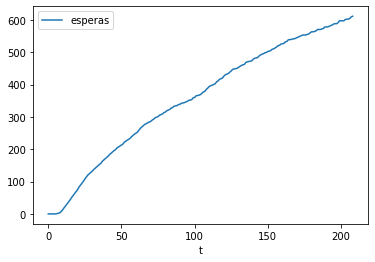

In [164]:
data = results.variables.StreetModel
ax = data.plot()

## Training

In [174]:
bestParameters = parameters
bestEsperado = results.variables.StreetModel.esperas.values[-1]
bestResults = results
t = 1000 #Trainning
for i in range(0,t):
    random.seed(random.randint(0,t))
    print("Iter:",i)
    parameters = {
    'agents': 20,
    'seed': eSeed,
    'cambia': random.randint(10,30),
    'cof' : i/1000,
    }
    arr = 0
    izq = 0
    aba = 0
    der = 0
    model = StreetModel(parameters)
    
    results = model.run()
    esperado = results.variables.StreetModel.esperas.values[-1]
    if(esperado<bestEsperado):
        bestEsperado = esperado
        bestParameters = parameters
        bestResults = results

Iter: 0
Completed: 224 steps
Run time: 0:00:00.281942
Simulation finished
Iter: 1
Completed: 224 steps
Run time: 0:00:00.263962
Simulation finished
Iter: 2
Completed: 224 steps
Run time: 0:00:00.279904
Simulation finished
Iter: 3
Completed: 224 steps
Run time: 0:00:00.313880
Simulation finished
Iter: 4
Completed: 224 steps
Run time: 0:00:00.268144
Simulation finished
Iter: 5
Completed: 224 steps
Run time: 0:00:00.309823
Simulation finished
Iter: 6
Completed: 224 steps
Run time: 0:00:00.275746
Simulation finished
Iter: 7
Completed: 224 steps
Run time: 0:00:00.273064
Simulation finished
Iter: 8
Completed: 224 steps
Run time: 0:00:00.260527
Simulation finished
Iter: 9
Completed: 224 steps
Run time: 0:00:00.256775
Simulation finished
Iter: 10
Completed: 224 steps
Run time: 0:00:00.289704
Simulation finished
Iter: 11
Completed: 224 steps
Run time: 0:00:00.250719
Simulation finished
Iter: 12
Completed: 224 steps
Run time: 0:00:00.250940
Simulation finished
Iter: 13
Completed: 224 steps
Run t

In [175]:
bestResults.variables.StreetModel

,esperas
t,
0,0
1,0
2,0
3,0
4,0
...,...
148,318
149,318
150,320


In [176]:
print("Mejores parametros:",bestParameters)
print("Minimo de espera:",bestEsperado)

Mejores parametros: {'agents': 20, 'seed': 42, 'cambia': 10, 'cof': 0.685}
Minimo de espera: 323


In [177]:
steps = len(bestResults.variables.StreetModel)
print(steps)

153


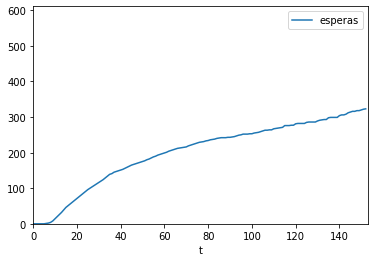

In [178]:
data = bestResults.variables.StreetModel
ax = data.plot()
ax.axis([0,steps,0,original]);

Tabla de posiciones para cada carro

In [179]:
bestResults.variables.CarAgent

pos_X  pos_Y
obj_id t                
1      0     45.0   95.0
       1     45.0   91.2
       2     45.0   87.4
       3     45.0   83.6
       4     45.0   79.8
...           ...    ...
20     148   45.0  -39.8
       149   45.0  -43.6
       150   45.0  -47.4
       151   45.0  -47.4
       152   45.0  -51.2

[3060 rows x 2 columns]

Escribir tabla en csv

In [180]:
df = pd.DataFrame()
df = df.assign(id=None)
df = df.assign(t=None)
df = df.assign(X=None)
df = df.assign(Y=None)
id = []
t = []
x = []
y = []
for i in range(0,bestParameters["agents"]):
    for j in range(0,steps):
        id.append(i+1)
        t.append(j)
for i in bestResults.variables.CarAgent.pos_X:
    x.append(i)
for i in bestResults.variables.CarAgent.pos_Y:
    y.append(i)
df['id'] = id
df['t'] = t
df['X'] = x
df['Y'] = y
df.to_csv("carros.csv",index=False)

Tabla de valores de encendido para cada semaforo

In [181]:
bestResults.variables.SemaforoAgent

on
obj_id t         
21     0     True
       1     True
       2     True
       3     True
       4     True
...           ...
24     148  False
       149  False
       150  False
       151  False
       152  False

[612 rows x 1 columns]

Escribir tabla en csv

In [182]:
df = pd.DataFrame()
df = df.assign(id=None)
df = df.assign(t=None)
df = df.assign(on=None)
id = []
t = []
on = []
for i in range(bestParameters["agents"],bestParameters["agents"]+4):
    for j in range(0,steps):
        id.append(i+1)
        t.append(j)
for i in bestResults.variables.SemaforoAgent.on:
    on.append(i)
df['id'] = id
df['t'] = t
df['on'] = on
df.to_csv("semaforos.csv",index=False)